<a href="https://colab.research.google.com/github/sunshineluyao/AMPL/blob/main/Solve_Cournot_oligopoly_model_via_collocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solve Cournot oligopoly model via collocation

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demapp07.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2022-Oct-22</i>
<hr>

## About

To illustrate implementation of the collocation method for implicit function problems, consider the example of Cournot oligopoly. In the standard microeconomic model of the firm, the firm maximizes profit by equating marginal revenue to marginal cost (MC). An oligopolistic firm, recognizing that its actions affect price, takes the marginal revenue to be $p + q\frac{dp}{dq}$, where $p$ is price, $q$ is quantity produced, and $\frac{dp}{dq}$ is the marginal impact of output on market price. The Cournot assumption is that the firm acts as if any change in its output will be unmatched by its competitors. This implies that

\begin{equation*}
    \frac{dp}{dq} = \frac{1}{D'(p)}
\end{equation*}

where $D(p)$ is the market demand curve.

Suppose we wish to derive the effective supply function for the firm, which specifies
the quantity $q = S(p)$ it will supply at any price. The firm's effective supply function is
characterized by the functional equation

\begin{equation*}
    p + \frac{S(p)}{D'(p)} - MC(S(p)) = 0
\end{equation*}

for all positive prices $p$. In simple cases, this function can be found explicitly.  However,
in more complicated cases, no explicit solution exists.

## Initial tasks

In [ ]:
!pip install compecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, NLP

## The model
### Parameters

Here, the demand elasticity and the marginal cost function parameter are

In [ ]:
alpha, eta = 1.0, 3.5

In [ ]:
D = lambda p: p**(-eta)

### Approximation structure

A degree-25 Chebychev basis on the interval [0.5, 3.0] is selected; also, the associated collocation nodes `p` are computed.

In [ ]:
n, a, b =  25, 0.5, 2.0
S = BasisChebyshev(n, a, b, labels=['price'], y=np.ones(n))
p = S.nodes

In [ ]:
S2 = BasisChebyshev(n, a, b, labels=['price'], l=['supply'])
S2.y = np.ones_like(p)

### Residual function

Suppose, for example, that

\begin{equation}
    D(p) = p^{-\eta} \quad\text{and}\quad MC(q) = \alpha\sqrt{q} + q^2
\end{equation}

Then the functional equation to be solved for S(p),

\begin{equation}
 \left[p - \frac{S(p)p^{\eta+1}}{\eta}\right] -\left[\alpha\sqrt{S(p)} + S(p)^2\right] = 0
\end{equation}

has no known closed-form solution.

In [ ]:
def resid(c):
    S.c = c  # update interpolation coefficients
    q = S(p) # compute quantity supplied at price nodes
    marginal_income = p - q * (p ** (eta+1) / eta)
    marginal_cost = alpha * np.sqrt(q) + q ** 2
    return  marginal_income - marginal_cost 

Notice that `resid` only takes one argument. The other parameters (`Q`, `p`, `eta`, `alpha`) should be declared as such in the main script, were Python's scoping rules will find them.

### Solve for effective supply function

Class `NLP` defines nonlinear problems. It can be used to solve `resid` by Broyden's method.

In [ ]:
cournot = NLP(resid)
S.c = cournot.broyden(S.c, tol=1e-12)

### Plot demand and effective supply for m=5 firms

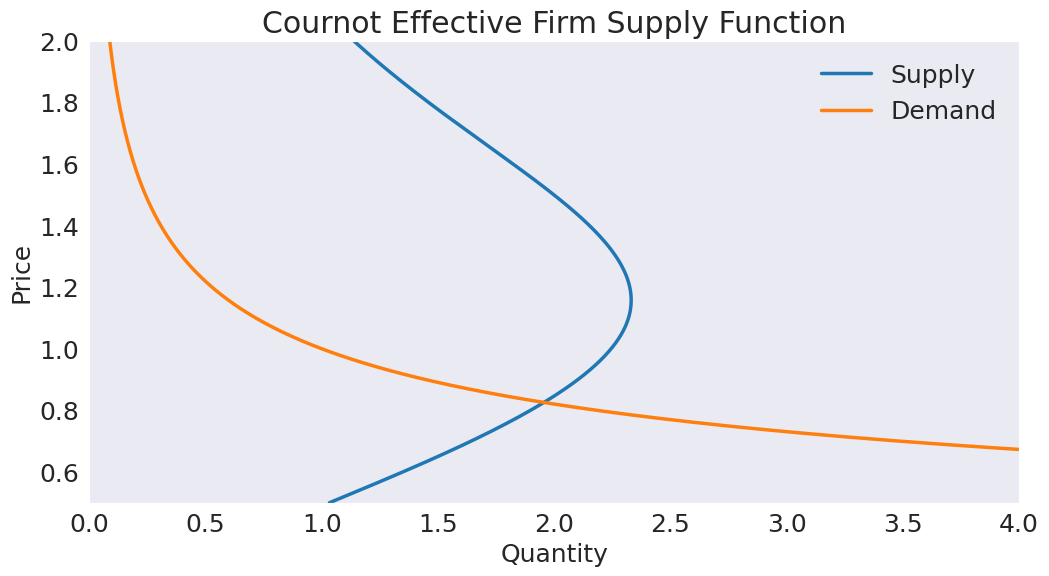

In [ ]:
prices = np.linspace(a, b, 501)

fig1, ax = plt.subplots()
ax.plot(5 * S(prices), prices, label='Supply')
ax.plot(D(prices), prices, label='Demand')

ax.set(title='Cournot Effective Firm Supply Function', 
       xlabel='Quantity',
       ylabel='Price',
       xlim=[0, 4],
       ylim=[0.5, 2])

ax.legend();

### Plot residual

Notice that `resid` does not take explicit parameters, so to evaluate it when prices are `prices` we need to assign `p = prices`.

In order to assess the quality of the approximation, one plots the residual function over the approximation domain. Here, the residual function is plotted by computing the residual at a refined grid of 501 equally spaced points.

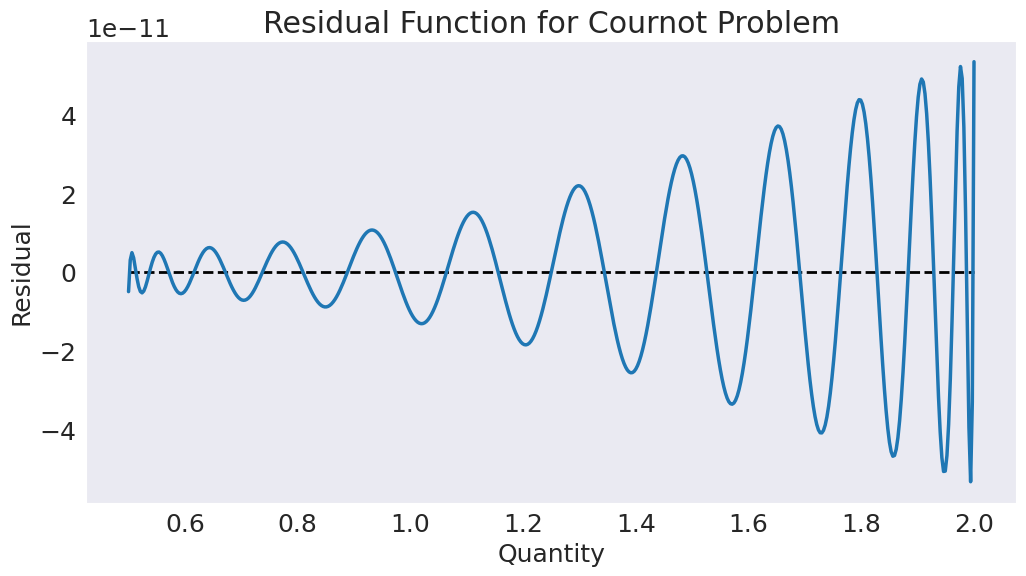

In [ ]:
p = prices
fig2, ax = plt.subplots()

ax.hlines(0, a, b, 'k', '--', lw=2)
ax.plot(prices, resid(S.c))
ax.set(title='Residual Function for Cournot Problem',
       xlabel='Quantity',
       ylabel='Residual');

### Plot demand and effective supply for m=1, 3, 5, 10, 15, 20 firms

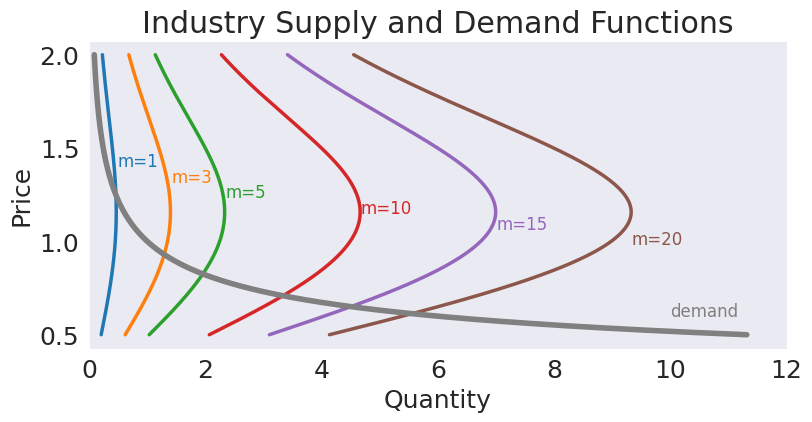

In [ ]:
fig3, ax = plt.subplots(figsize=[9,4])

ax.set(title='Industry Supply and Demand Functions', 
       xlabel='Quantity',
       ylabel='Price',
       xlim=[0, 12])

lcolor = [z['color']  for z in plt.rcParams['axes.prop_cycle']]

for i, m in enumerate([1, 3, 5, 10, 15, 20]):
    ax.plot(m*S(prices), prices) # supply
    ax.annotate(f'm={m:d}', [m*S(1.2)+.025, 1.4-i/12], color=lcolor[i], fontsize=12)
        
ax.plot(D(prices), prices, linewidth=4, color='grey') # demand
ax.annotate('demand', [10, 0.6], color='grey', fontsize=12);

### Plot equilibrium price as a function of number of firms m

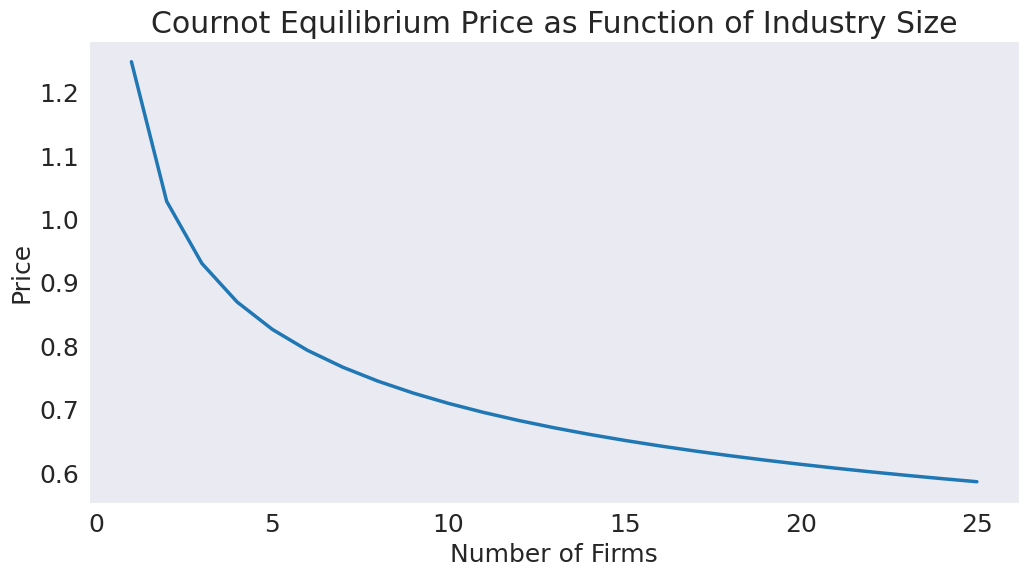

In [ ]:
m = np.arange(1,26)
x0 = np.full_like(m, 0.7, dtype=float) #initial guess
eqprices = NLP(lambda p: m*S(p) - D(p)).broyden(x0)

fig4, ax = plt.subplots()
ax.set(title='Cournot Equilibrium Price as Function of Industry Size', 
       xlabel='Number of Firms',
       ylabel='Price')
ax.plot(m, eqprices);